In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import csv
import numpy as np
import matlab.engine
import math
from matplotlib.colors import ListedColormap
from matplotlib import cm
from scipy.signal import find_peaks
eng = matlab.engine.start_matlab()
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import numpy.matlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import signal
from itertools import combinations
import math
import os
from numpy.fft import fft, ifft
import csv

In [2]:
def load_csvfile(filename):
    # reading csv file
    # initializing the titles and rows list
    fields = []
    rows = []

    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)

        # extracting field names through first row
        fields = next(csvreader)

        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)
            
        rows.insert(0,fields)
    return fields, rows


def cartsph(x,y,z):
    # calculate rho
    rho = np.sqrt(pow(x,2) + pow(y,2) + pow(z,2))

    #calculate phi
    phi = np.arctan2(y, x)

    # calculate theta
    theta = np.arccos(z / rho)
    z = matlab.double(z)
    rho1 = np.sqrt(pow(x,2) + pow(y,2) )
    rho1=matlab.double(rho1)
    theta = eng.atan2(z,rho1)
    theta = np.array(theta)
    
    return phi,theta, rho

def sphcart(phi,theta,rho):
    x = rho * np.cos(np.array(theta)) * np.cos(np.array(phi))
    y = rho * np.cos(np.array(theta)) * np.sin(np.array(phi))
    z = rho * np.sin(np.array(theta))
    return x,y,z

    



In [3]:
import numpy as np
from scipy.signal import windows
from scipy.signal import fftconvolve

folder = 'data_1.5.0'
filepath = os.getcwd() +"\data\\data_1.5.0\\alldat.csv"


# [fields, speakerNames] = load_csvfile(filepath)
df = pd.read_csv(filepath, sep=',',decimal='.')

df1=df[0:480001]
hd=df.columns[0:-3]
hd =df1[hd]
hd = hd.to_numpy()

# Assuming you have your impulse responses in a variable called impulse_responses
impulse_responses = hd #np.random.rand(96000, 7)  # Replace with your actual data

# Define parameters
sampling_rate = 48000
window_length = 62
speed_of_sound = 345  # Speed of sound in m/s

# Define microphone positions in Cartesian coordinates (in meters)
microphone_positions = np.array([[1, 0, 0], [0, -0.7071, -0.7071], [0, -0.7071, 0.7071],
                                 [-1, 0, 0], [0, 0.7071, 0.7071], [0, 0.7071, -0.7071], [0, 0, 0]]) * (0.1 / 2)

# Normalize the impulse responses
impulse_responses /= np.max(np.abs(impulse_responses))

# Create a Hann window
window = windows.hann(window_length)

# Initialize an empty array for the windowed impulse responses
windowed_impulse_responses = np.zeros_like(impulse_responses)

# Apply windowing to reduce spectral leakage
for i in range(7):
    for j in range(0, 96000, window_length):
        segment = impulse_responses[j:j + window_length, i]
        if len(segment) < window_length:
            continue  # Skip the last segment if it's shorter than the window
        windowed_segment = segment * window
        windowed_impulse_responses[j:j + window_length, i] = windowed_segment

# Calculate time delays for each microphone
microphone_distances = np.linalg.norm(microphone_positions, axis=1)
time_delays = microphone_distances / speed_of_sound

# Apply delay compensation
for i in range(7):
    delay_samples = int(np.round(time_delays[i] * sampling_rate))
    impulse_responses[:, i] = np.roll(impulse_responses[:, i], delay_samples)

# Perform frequency analysis using the Discrete Fourier Transform (DFT)
impulse_responses_fft = np.fft.fft(windowed_impulse_responses, axis=0)
frequency_bins = np.fft.fftfreq(window_length, 1 / sampling_rate)

# Optionally, apply noise reduction using spectral subtraction (adjust parameters as needed)
# For simplicity, we'll use a basic spectral subtraction approach. You may need a more advanced noise reduction method.
noise_estimation_start_bin = 10
noise_estimation_end_bin = 20
noise_floor = np.mean(np.abs(impulse_responses_fft[noise_estimation_start_bin:noise_estimation_end_bin]), axis=0)
signal_to_noise_ratio = np.abs(impulse_responses_fft) / noise_floor
threshold = 10  # Adjust the threshold based on your noise characteristics
impulse_responses_fft_cleaned = impulse_responses_fft * (signal_to_noise_ratio > threshold)

# Inverse FFT to obtain cleaned impulse responses
impulse_responses_cleaned = np.fft.ifft(impulse_responses_fft_cleaned, axis=0).real

# Now, the impulse_responses_cleaned matrix is preprocessed and can be used in your machine learning pipeline.




In [4]:
impulse_responses_cleaned.shape

(480000, 7)

In [5]:
dof = pd.DataFrame(windowed_impulse_responses  , columns = ['dat1','dat2','dat3','q4','q5','q6','q7'])
dof

,dat1,dat2,dat3,q4,q5,q6,q7
0,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00
1,3.385422e-07,6.001430e-08,9.797206e-08,1.156686e-08,2.616008e-07,-7.976259e-09,-2.277466e-07
2,1.657530e-07,2.721624e-07,-2.568149e-07,3.468535e-07,-1.381275e-07,-4.512166e-08,-6.169696e-07
3,6.440405e-07,-2.566994e-07,4.354722e-07,-5.409024e-08,7.930179e-07,-4.263044e-07,9.121997e-07
4,2.449886e-06,1.097387e-06,2.190725e-06,-4.818785e-07,2.830530e-06,2.146181e-06,-3.207124e-06
...,...,...,...,...,...,...,...
479995,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
479996,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
479997,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
479998,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [6]:
train_cols = df.columns[0:-3]
label = df.columns[-3:]
# X = df[train_cols]

y = df[label]
lab=df[label]
lab = lab.head(dof.shape[0])
result = pd.concat([dof, lab], axis=1)
df=result
# df =pd.concat([dof, y], axis=1)
df.dropna(how='any')    #to drop if any value in the row has a nan
df.dropna(how='all')
df = df.dropna()  # Remove rows with missing values

df = df.loc[(df!=0).any(axis=1)]
df = df.reset_index(drop=True)  # Reset index


train_cols = df.columns[0:-3]
label = df.columns[-3:]
X = df[train_cols]
y = df[label]
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [7]:
df

,dat1,dat2,dat3,q4,q5,q6,q7,a1,a2,a3
0,3.385422e-07,6.001430e-08,9.797206e-08,1.156686e-08,2.616008e-07,-7.976259e-09,-2.277466e-07,0.000000,0.000000,0.000000
1,1.657530e-07,2.721624e-07,-2.568149e-07,3.468535e-07,-1.381275e-07,-4.512166e-08,-6.169696e-07,0.000000,0.000000,0.000000
2,6.440405e-07,-2.566994e-07,4.354722e-07,-5.409024e-08,7.930179e-07,-4.263044e-07,9.121997e-07,0.000000,0.000000,0.000000
3,2.449886e-06,1.097387e-06,2.190725e-06,-4.818785e-07,2.830530e-06,2.146181e-06,-3.207124e-06,0.000000,0.000000,0.000000
4,-1.142388e-05,-3.678238e-07,5.398097e-07,9.603591e-07,3.602916e-06,1.487615e-06,-7.594997e-07,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
228557,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-303.161469,616.622192,42.432587
228558,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-583.586548,365.067596,9.615999
228559,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-580.351807,370.304962,4.005260
228560,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-580.348694,370.322693,4.058674


*************************************


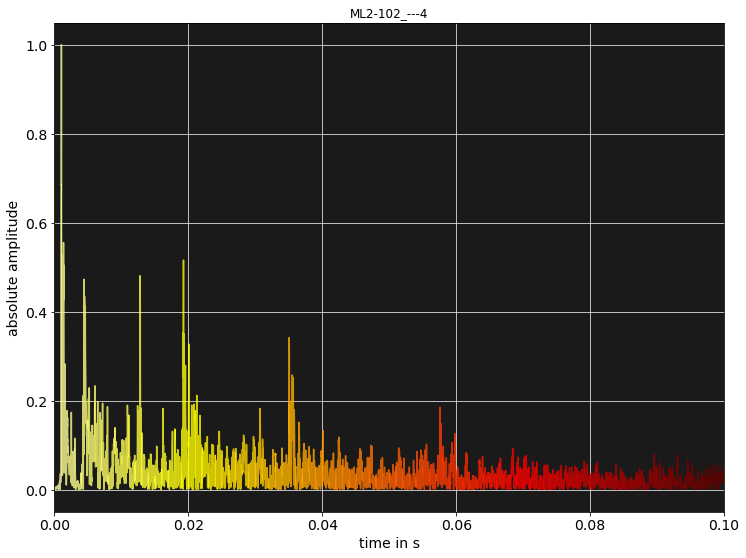

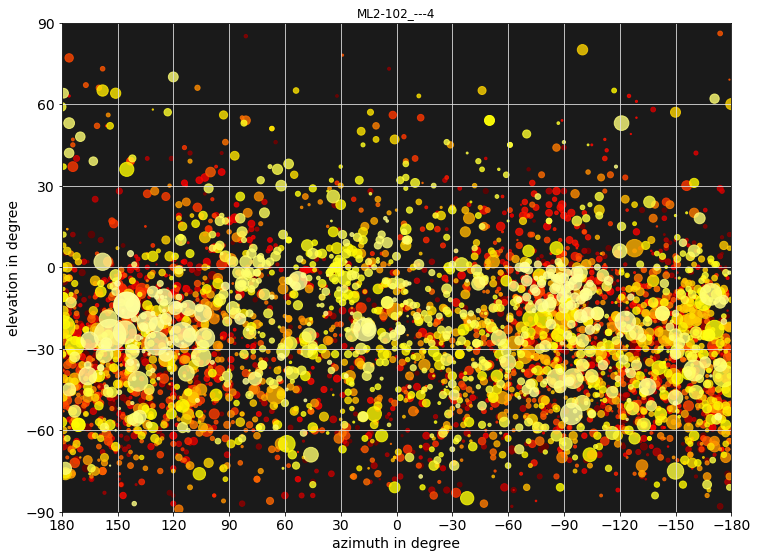

In [8]:
filepath = os.getcwd() +"\data\\" + folder+"\\data_7_9.csv"


[fields, speakerNames] = load_csvfile(filepath)



print("*************************************")

filepath = os.getcwd() +"\data\\" + folder+"\\data_10_11.csv"
[fields, fst] = load_csvfile(filepath)


filepath = os.getcwd() +"\data\\" + folder+"\\data_1_4.csv"
[fields, info] = load_csvfile(filepath)
# len(speakerNames[1][0])
for idxSpeaker in range (1): #len(speakerNames[1][0])):
    
    fs =  int(fst[1][0])   # Sampling Rate (in Hz). Only 48 kHz is recommended. Other sampling rates have not been tested.
    
    #RAUMABHÄNGIG----------------------------------------------------------
    MixingTime      = 0.1                 # Mixing time (in seconds) of the room for rendering. Data after the mixing time will be rendered
    BRIRLength      = 0.25                  # Duration of the rendered BRIRs (in seconds)

    SpeedSound      = 345                  # Speed of sound in m/s (for SDM Toolbox DOA analysis)
    
    ArrayGeometry = np.array(  [[1, 0 ,0],[0, -0.7071, -0.7071],[0, -0.7071, 0.7071],[-1, 0 ,0],[0, 0.7071, 0.7071],[0, 0.7071, -0.7071],
                     [0, 0, 0]])*(0.1/2)
    SDM_Struct = eng.createSDMStruct('c',SpeedSound,'fs',fs,'micLocs',ArrayGeometry,'winLen',62)
    
    filepath = os.getcwd() +"\data\\" + folder+"\\ir"+str(idxSpeaker+1)+".csv"
    [fields, ir] = load_csvfile(filepath)
#     ir = ig
    
    
    desired_array = [list(map(float, (numeric_string)))  for numeric_string in ir]
    SRIR = np.array(desired_array)
    
#     DOA = eng.SDMPar(SRIR, SDM_Struct)
    filepath = os.getcwd() +"\data\\" + folder+"\\new_doa5b.csv"
    [fields, doa] = load_csvfile(filepath)
    
    DOA = doa
    P = SRIR[:,6]
    
    res = 1 # DOA resolution of the polar response
    t_steps = 1 #in ms
    
     
    ir_threshold = 0.5 # treshold level for the beginning of direct sound
     
    #Find the direct sound
    
    
    ind = np.where(abs(P)/max(abs(P)) > ir_threshold)
    ind = ind[0][0] 
    pre_threshold = round(0.001*fs)                   # go back 1 ms
    t_ds = ind - pre_threshold                  # direct sound begins from this sample
    
    # make sure that the time index of direct sound is greater than or equal to 1
    t_ds = max(t_ds, 1)
    
    t_end = MixingTime/(t_steps/1000)
    
    
    ts = np.arange(1, (t_end/1000*fs)+(t_steps/1000*fs), (t_steps/1000*fs))
    ts = list(map(round, ts))
    
    
#     Iterate through different time windows
    HS = np.zeros([len(ts)-1,361,181])
    
    for k in range(len(ts)-1):
        
        t1 = int(round(t_ds+ts[k]))
        t2 = int(round(t_ds+ts[k+1]+1))
        
        
        tmpDOA = DOA[t1:t2]
        tmpP = P[t1:t2]
        
        
        az_corr = 0
        el_corr = 0
        
        first_c = []
        second_c = []
        third_c = []
        
        
        for tem in tmpDOA:
            first_c.append([float(tem[0])])
            second_c.append([float(tem[1])])
            third_c.append([float(tem[2])])
         
        first_c =np.array(first_c)
        second_c =np.array(second_c)
        third_c =np.array(third_c)
        
        
        [az,el,nn]=cartsph(first_c,second_c,third_c)
        [x,y,z] = sphcart(az+az_corr,el+el_corr,1)
        [az,el,mm] = cartsph(x,y,z)
        
#         Find the closest direction in the grid for each image-source
        AZ = np.round(az*180/math.pi/res)*res
        EL = np.round(el*180/math.pi/res)*res
        
#         Pressure to energy
        A2 = pow(tmpP,2)
        A2 = A2
        
#         Doughnut weighting for angles, i.e. cosine weighting
        doa_az_vec = np.arange(-180, 181,res )
        doa_el_vec = np.arange(-90, 91,res )
        
        H = np.zeros([len(doa_az_vec), len(doa_el_vec)])
        
        for idx in range(len(A2)):
            if ~np.isnan(AZ[idx]) and ~np.isnan(EL[idx]):
                idxAz= np.where(AZ[idx]==doa_az_vec)
                idxEl=np.where(EL[idx]==doa_el_vec)
                
#                 print(idxAz, idxEl)
                idxAz =idxAz[0][0]
                idxEl = idxEl[0][0]
                
                H[idxAz][idxEl] = H[idxAz][idxEl] + A2[idx]
        HS[k,:,:] = H
        
    noisefloor_dB = -100
    maxdB = 10*np.log10(np.max(HS))
    
    mph = 10**(noisefloor_dB/10)


    az_tic = np.arange(-180, 181, 30)
    el_tic =np.arange(-90, 91, 30)

    Scale = 1000;
    
    
    
    idxPeaksAzEl=[]
    A=[] 
    tmpA2=[] 
    tmpH=[]
    peak_Az_El_R= [[0]]*k
    for idxk in np.arange(k-1,-1,-1):
        tmpH =  HS[idxk,:,:]
        count=0

        for idx in range(len(tmpH)):
            try:
                whr = np.where(tmpH[idx]>mph)
                whr = whr[0][0]
                [loc,pks] = find_peaks(tmpH[idx], height=mph)
                pks = pks['peak_heights']
                
            except:
                pks =[]
                loc =[]
            
            if len(pks) !=0:
                for idxC in range(len(pks)):
                    count=count+1
                    idxPeaksAzEl.append([idx,loc[idxC]])

        for idx in range(count):
            tmpA2.append( tmpH[idxPeaksAzEl[idx][0]][idxPeaksAzEl[idx][1]])
        
        if count!=0:            
            peak_Az_El_R[idxk] = [idxPeaksAzEl,tmpA2]
            
        idxPeaksAzEl=[]
        A=[] 
        tmpA2=[] 
        tmpH=[]
#             print((np.array(allidpa)).shape)
#           print(peak_Az_El_R[0])
            
    plot_mode = "dark"
    
    #Sense_of_Rotation_Az = "clockwise"
    
    Sense_of_Rotation_Az = "counterclockwise"
    
    if plot_mode == "dark":
            stepw_color = math.floor(230/(len(ts)-1))
            rng = np.arange(230,0,-stepw_color) 
            newcolors = cm.hot(rng)
            
            BackColor = [0.1, 0.1, 0.1]
            GridColor = [0.9, 0.9, 0.9]
            AlphaColor = 0.8;
    elif plot_mode == "light":
        
        stepw_color = math.floor(230/(len(ts)-1))
        rng = np.arange(1,231, stepw_color) # rng here stand for range
        newcolors = cm.hot(rng)
        
        BackColor = [1 ,1 ,1]
        GridColor = [0.1, 0.1, 0.1]
        AlphaColor = 0.8
    else:
        print("do nothing")
        
    
    if len(newcolors)<len(ts):
        print('Farbabstufung zu klein')
    
    DefFonSiz = 14
    
#     fig, ax = plt.subplots()
    plt.figure(figsize=(12,9))
    ax = plt.axes()
    ax.set_facecolor(BackColor)
    
    tittle = info[1][1]+'_---'+str(4)
    plt.title(tittle)
    
    for k in range(len(ts)-1):
        t1 = t_ds+ts[k]
        t2 = t_ds+ts[k+1]+1
        
        x_data = (np.arange(ts[k],ts[k+1]+1))/fs
        y_data = (abs(P[t1:t2])/max(abs(P)))
        plt.plot(x_data, y_data,   color = newcolors[k,:] ,alpha=AlphaColor)
   
    plt.xlabel('time in s', fontsize = DefFonSiz)
    plt.ylabel('absolute amplitude', fontsize = DefFonSiz)
    plt.xticks(fontsize = DefFonSiz)
    plt.yticks(fontsize = DefFonSiz)
    plt.grid(color= GridColor)
    plt.xlim((0, t_end/1000))
    
    plt.show()
    
    
#      %% Plot DoA IR (abs pressure)fig-3

    
    plt.figure(figsize=(12,9))
    ax = plt.axes()
    ax.set_facecolor(BackColor)
    
    tittle = info[1][1] +'_---'+str(4)
    plt.title(tittle)
    num_iter = np.arange(len(peak_Az_El_R)-1,-1,-1)

    for idxk in (num_iter):
        tmp = peak_Az_El_R[idxk]
        if len(tmp) != 0 and tmp !=[0]:
            deno =10**(maxdB/10)
            div_result = [dv / deno for dv in tmp[1]]
            
            A =np.sqrt(div_result)*Scale
            
            A = np.array(A)
            fin = np.where(A!=0)
            
            h_tmp = np.array(tmp[0])
            h_tmp = h_tmp[fin]
            A=A[fin]
            
            [tmp1,tmp2]=np.split(h_tmp, 2, axis=1)
            x_data1 =[doa_az_vec[dv[0]] for dv in tmp1]
            y_data1 =[doa_el_vec[dv[0]] for dv in tmp2]
            
            plt.scatter( x_data1 , y_data1,A, color = newcolors[idxk,:] ,alpha=AlphaColor) #,A,'filled','MarkerFaceColor',newcolors(idxk,:),'MarkerFaceAlpha',AlphaColor)
            

    plt.xticks(az_tic)
    plt.yticks(el_tic)
    plt.xticks(fontsize = DefFonSiz)
    plt.yticks(fontsize = DefFonSiz)
    plt.xlim((-180, 180))
    plt.ylim((-90, 90))

    plt.xlabel("azimuth in degree", fontsize = DefFonSiz)
    plt.ylabel("elevation in degree",fontsize = DefFonSiz)
    plt.grid(color= GridColor)
    plt.gca().invert_xaxis()
    plt.show()
    

    